In [1]:
import pickle
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho']
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho']
lat_rho = np.transpose(lat_rho, axes=(1, 0))
z_r = np.load('/home/z5297792/MRes/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
h = dataset.variables['h']
h = np.transpose(h, (1, 0))
previous_file_idx = -1
TOTAL_NUM_DAYS = len(daydic)

In [31]:
import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357000  # in meters
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return EARTH_RADIUS * c

def grid_finder(i_search, j_search, SEARCH_WIDTH):
    i_left = 0
    i_right = 0
    j_down = 0
    j_up = 0
    while (i_search - i_left >= 0 and 
           distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search], 
                    lat_rho[i_search - i_left, j_search], lon_rho[i_search - i_left, j_search])) < SEARCH_WIDTH/2:
        i_left += 1
    while (i_search + i_right < lon_rho.shape[0] and
           distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search],
                    lat_rho[i_search + i_right, j_search], lon_rho[i_search + i_right, j_search])) < SEARCH_WIDTH/2:
        i_right += 1
    while (j_search - j_down >= 0 and 
           distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search], 
                    lat_rho[i_search, j_search - j_down], lon_rho[i_search, j_search - j_down])) < SEARCH_WIDTH/2:
        j_down += 1
    while (j_search + j_up < lon_rho.shape[1] and
           distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search],
                    lat_rho[i_search, j_search + j_up], lon_rho[i_search, j_search + j_up])) < SEARCH_WIDTH/2:
        j_up += 1

    i_left = max(i_search - i_left + 1, 0) #+1
    i_right = min(i_search + i_right, lon_rho.shape[0])
    j_up = min(j_search + j_up, lon_rho.shape[1])
    j_down = max(j_search - j_down + 1, 0)#+1

    return i_left, i_right, j_down, j_up

edata = eddies['Eddy277'].iloc[15]
t = extract_number(edata.name)

t_mod = t % 30
file_idx = np.floor(t/30)
if file_idx != previous_file_idx:
    fnumber = '0'+str(round(1461+ file_idx*30))
    u = np.load('/srv/scratch/z5297792/Climatology/u_v/u_'+fnumber+'.npy')
    v = np.load('/srv/scratch/z5297792/Climatology/u_v/v_'+fnumber+'.npy')
    CurSpeed = np.load('/srv/scratch/z5297792/Climatology/ow_and_cur_speeds/cur_speed_'+fnumber+'.npy')
    previous_file_idx = file_idx

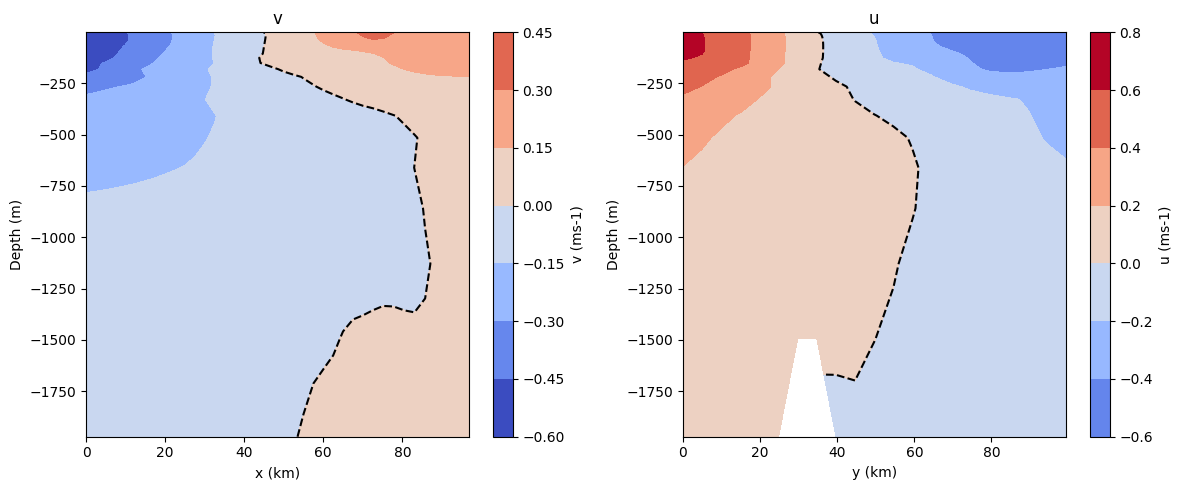

In [32]:
R = np.sqrt((lon_rho - edata.Lon)**2 + (lat_rho - edata.Lat)**2)
i_search, j_search = np.argwhere(R == np.min(R))[0]
SEARCH_WIDTH = 100000
DEPTH_LVL_LIMIT = 25

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# First subplot
i_left, i_right, _, _ = grid_finder(i_search, j_search, SEARCH_WIDTH)

v_cross = v[i_left:i_right, j_search, :DEPTH_LVL_LIMIT, t_mod]
v_data_range = np.max(np.abs(v_cross))
x = distance(lat_rho[i_left, j_search], lon_rho[i_left, j_search], lat_rho[i_left:i_right, j_search], lon_rho[i_left:i_right, j_search])/1000
z = z_r[150, 150, :DEPTH_LVL_LIMIT]

X, Z = np.meshgrid(x, z)

c1 = axs[0].contourf(X, Z, v_cross.T, cmap=plt.get_cmap('coolwarm'), vmin=-v_data_range, vmax=v_data_range)
c1_contour = axs[0].contour(X, Z, v_cross.T, levels=[0], colors='black', linestyles='--')
axs[0].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (m)')
axs[0].set_title('v')
fig.colorbar(c1, ax=axs[0], label='v (ms-1)')

# Second subplot
_, _, j_down, j_up = grid_finder(i_search, j_search, SEARCH_WIDTH)

u_cross = u[i_search, j_down:j_up, :DEPTH_LVL_LIMIT, t_mod]
u_data_range = np.nanmax(np.abs(u_cross))
y = distance(lat_rho[i_search, j_down], lon_rho[i_search, j_down], lat_rho[i_search, j_down:j_up], lon_rho[i_search, j_down:j_up])/1000
z = z_r[150, 150, :DEPTH_LVL_LIMIT]

Y, Z = np.meshgrid(y, z)

c2 = axs[1].contourf(Y, Z, u_cross.T, cmap=plt.get_cmap('coolwarm'), vmin=-u_data_range, vmax=u_data_range)
c2_contour = axs[1].contour(Y, Z, u_cross.T, levels=[0], colors='black', linestyles='--')
axs[1].set_xlabel('y (km)')
axs[1].set_ylabel('Depth (m)')
axs[1].set_title('u')
fig.colorbar(c2, ax=axs[1], label='u (ms-1)')

plt.tight_layout()
plt.show()


## MOCA - 2 Transect

In [33]:
def eddy_centric_grid_distances(i_search, j_search, i_left, i_right, j_down, j_up):
    lonc = lon_rho[i_search, j_search]
    latc = lat_rho[i_search, j_search]
    def make_left_values_negative(arr):
        zero_index = np.where(arr == 0)[0]
        if zero_index.size == 0:
            return arr
        zero_index = zero_index[0]
        arr[:zero_index] = -np.abs(arr[:zero_index])
        return arr

    x1 = make_left_values_negative(distance(latc, lonc, lat_rho[i_left:i_right,j_search], lon_rho[i_left:i_right,j_search]))
    y1 = [0] * len(x1)
    y2 = make_left_values_negative(distance(latc, lonc, lat_rho[i_search,j_down:j_up], lon_rho[i_search,j_down:j_up]))
    x2 = [0] * len(y2)
    return x1, y1, x2, y2
    
def polynomial_fit_with_error(x, y, degree=1):
    mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[mask]
    y = y[mask]
    if degree not in [0, 1]:
        raise ValueError("Degree must be 0 or 1.")
    coefficients, cov = np.polyfit(x, y, degree, cov=True)  # coefficients = [slope, intercept]
    y_fit = np.polyval(coefficients, x)
    residuals = y - y_fit
    std_err_coeffs = np.sqrt(np.diag(cov))
    ss_total = np.sum((y - np.mean(y))**2)
    ss_residuals = np.sum(residuals**2)
    r_squared = 1 - (ss_residuals / ss_total)
    return coefficients, std_err_coeffs, r_squared

def haversine_distance(lat1, lon1, bearing, distance):
    R = 6371000
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    bearing = math.radians(bearing)
    
    lat2 = math.asin(math.sin(lat1) * math.cos(distance / R) +
                     math.cos(lat1) * math.sin(distance / R) * math.cos(bearing))
    
    lon2 = lon1 + math.atan2(math.sin(bearing) * math.sin(distance / R) * math.cos(lat1),
                             math.cos(distance / R) - math.sin(lat1) * math.sin(lat2))
    
    lat2 = math.degrees(lat2)
    lon2 = math.degrees(lon2)
    
    return lat2, lon2

def true_bearing(x, y):
    angle_radians = math.atan2(y, x)
    angle_degrees = math.degrees(angle_radians)
    bearing = (90 - angle_degrees) % 360
    return bearing

def rotate_30_clockwise(x, y):
    theta = np.deg2rad(30)
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    points = np.vstack((x, y))
    rotated_points = rotation_matrix @ points
    x_rotated, y_rotated = rotated_points
    return x_rotated, y_rotated

def is_pos_def(Q):
    eigenvalues = np.linalg.eigvals(Q)
    return np.all(eigenvalues > 0)

In [34]:
R = np.sqrt((lon_rho - edata.Lon)**2 + (lat_rho - edata.Lat)**2)
i_search, j_search = np.argwhere(R == np.min(R))[0]

SEARCH_WIDTH = 100000

i_left, i_right, j_down, j_up = grid_finder(i_search, j_search, SEARCH_WIDTH)

x1, y1, x2, y2 = eddy_centric_grid_distances(i_search, j_search, i_left, i_right, j_down, j_up)

x = x1
y = y2

depth_dics = {}
for depth_lvl in range(25):
    u1 = u[i_left:i_right, j_search, depth_lvl, t_mod]
    v1 = v[i_left:i_right, j_search,depth_lvl, t_mod]
    u2 = u[i_search, j_down:j_up, depth_lvl, t_mod]
    v2 = v[i_search, j_down:j_up, depth_lvl, t_mod]
    
    As, dAs, r2A = polynomial_fit_with_error(x, u1, degree=1)
    A1, A0 = As
    Bs, dBs, r2B = polynomial_fit_with_error(x, v1, degree=1)
    B1, B0 = Bs
    Cs, dCs, r2C = polynomial_fit_with_error(y, u2, degree=1)
    C1, C0 = Cs
    Ds, DAs, r2D = polynomial_fit_with_error(y, v2, degree=1)
    D1, D0 = Ds
    
    if r2A < r2B:
        alpha = A0
    else:
        alpha = C0
    if r2B < r2D:
        beta = B0
    else: 
        beta = D0
    if r2A < r2D:
        gamma = A1
    else:
        gamma = -D1
    
    q12 = -gamma/2
    q11 = B1/2
    q22 = -C1/2

    Q = np.array([[q11, q12], [q12, q22]])

    if is_pos_def(Q):
        yc = (q11*alpha+q12*beta)/(2*q11*q22-2*q12**2)
        xc = (alpha*q12+beta*q22)/(2*q12**2-2*q11*q22)
        dist = np.sqrt(xc**2+yc**2)
        bearing = true_bearing(xc, yc) + 30 # account for grid rotation
        latc, lonc = haversine_distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search], bearing, dist)
    
        R = np.sqrt((lon_rho - lonc)**2 + (lat_rho - latc)**2)
        ic, jc = np.argwhere(R == np.min(R))[0]
    
    else:
        yc = np.nan
        xc = np.nan
        ic = np.nan
        jc = np.nan
    
    dfx = pd.DataFrame({
        'x': x1,
        'y': y1,
        'u1': u1,
        'v1': v1,
    })
    dfy = pd.DataFrame({
        'x': x2,
        'y': y2,
        'u2': u2,
        'v2': v2
    })

    depth = float(z_r[150,150,depth_lvl])
    
    depth_dics['Depth'+str(depth_lvl)] = {'dfx': dfx, 'dfy': dfy, 'q11': q11, 'q12': q12, 'q22': q22, 'xc': xc, 'yc': yc, 'ic': ic, 'jc': jc, 'Depth': depth}



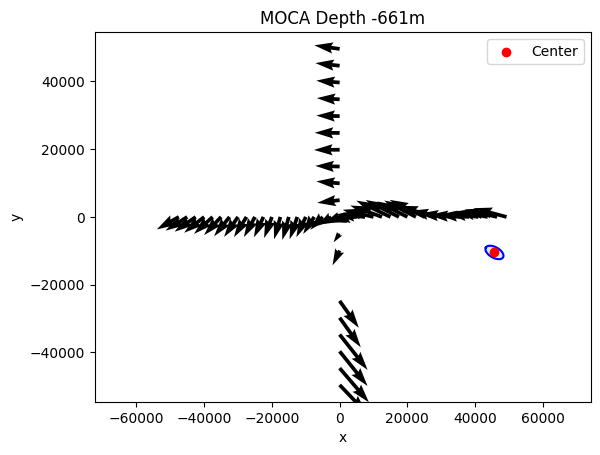

In [36]:
depth_lvl = 'Depth20'

x1 = depth_dics[depth_lvl]['dfx'].x
y1 = depth_dics[depth_lvl]['dfx'].y
x2 = depth_dics[depth_lvl]['dfy'].x
y2 = depth_dics[depth_lvl]['dfy'].y

q11 = depth_dics[depth_lvl]['q11']
q12 = depth_dics[depth_lvl]['q12']
q22 = depth_dics[depth_lvl]['q22']
xc = depth_dics[depth_lvl]['xc']
yc = depth_dics[depth_lvl]['yc']
depth = depth_dics[depth_lvl]['Depth']

plt.quiver(x1,y1,u1,v1)
plt.quiver(x2,y2,u2,v2)

# Ellipse
s = 5.991

# if edata.Vort > 0:
#     sgn = 1
# elif edata.Vort < 0:
#     sgn = -1
Q = np.array([[q11, q12], [q12, q22]])
num_points = 100
theta = np.linspace(0, 2 * np.pi, num_points)
ellipse = np.array([np.cos(theta), np.sin(theta)])
eigvals, eigvecs = np.linalg.eig(Q)

if np.any(eigvals <= 0):
    raise ValueError("Matrix Q is not positive definite. Eigenvalues: {}".format(eigvals))

axes = np.sqrt(s / eigvals)
ellipse_transformed = eigvecs @ np.diag(axes) @ ellipse
ellipse_transformed[0, :] += xc
ellipse_transformed[1, :] += yc

plt.fill(ellipse_transformed[0, :], ellipse_transformed[1, :], color='lightblue', alpha=0.5)
plt.plot(ellipse_transformed[0, :], ellipse_transformed[1, :], color='blue')
plt.scatter([xc], [yc], color='red', zorder=5, label='Center')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('MOCA Depth '+str(round(depth))+'m')
plt.axis('equal')
plt.show()

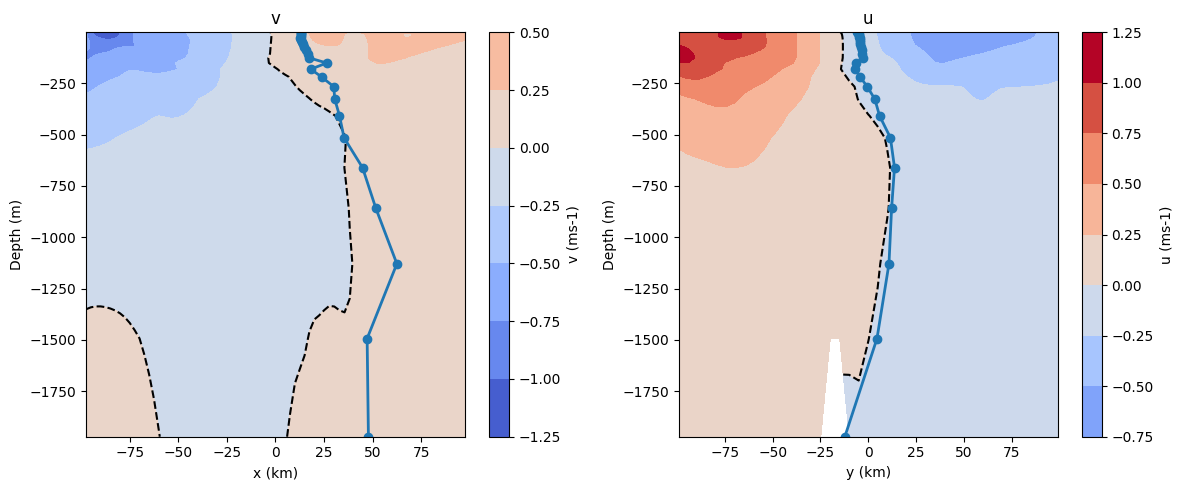

In [37]:
R = np.sqrt((lon_rho - edata.Lon)**2 + (lat_rho - edata.Lat)**2)
i_search, j_search = np.argwhere(R == np.min(R))[0]

DISPLAY_WIDTH = 200000
depth_lvl_limit = 25

i_left, i_right, j_down, j_up = grid_finder(i_search, j_search, DISPLAY_WIDTH)

x, _, _, y = eddy_centric_grid_distances(i_search, j_search, i_left, i_right, j_down, j_up)

x = x/1000
y = y/1000

xc_raw = []
yc_raw = []
zc = []
for depth_dic in depth_dics:
    xc_raw.append(depth_dics[depth_dic]['xc'])
    yc_raw.append(depth_dics[depth_dic]['yc'])
    zc.append(depth_dics[depth_dic]['Depth'])

xc, yc = rotate_30_clockwise(xc_raw, yc_raw)

xc = xc/1000
yc = yc/1000

z = z_r[150, 150, :depth_lvl_limit]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# First subplot

v_cross = v[i_left:i_right, j_search, :DEPTH_LVL_LIMIT, t_mod]
v_data_range = np.nanmax(np.abs(v_cross))

X, Z = np.meshgrid(x, z)

c1 = axs[0].contourf(X, Z, v_cross.T, cmap=plt.get_cmap('coolwarm'), vmin=-v_data_range, vmax=v_data_range)
c1_contour = axs[0].contour(X, Z, v_cross.T, levels=[0], colors='black', linestyles='--')
axs[0].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (m)')
axs[0].set_title('v')
axs[0].plot(xc, zc, 'o-', linewidth=2)
fig.colorbar(c1, ax=axs[0], label='v (ms-1)')

# Second subplot

u_cross = u[i_search, j_down:j_up, :DEPTH_LVL_LIMIT, t_mod]
u_data_range = np.nanmax(np.abs(u_cross))

Y, Z = np.meshgrid(y, z)

c2 = axs[1].contourf(Y, Z, u_cross.T, cmap=plt.get_cmap('coolwarm'), vmin=-u_data_range, vmax=u_data_range)
c2_contour = axs[1].contour(Y, Z, u_cross.T, levels=[0], colors='black', linestyles='--')
axs[1].set_xlabel('y (km)')
axs[1].set_ylabel('Depth (m)')
axs[1].set_title('u')
axs[1].plot(yc, zc, 'o-', linewidth=2)
fig.colorbar(c2, ax=axs[1], label='u (ms-1)')

plt.tight_layout()
plt.show()

## MOCA - 1 Transect

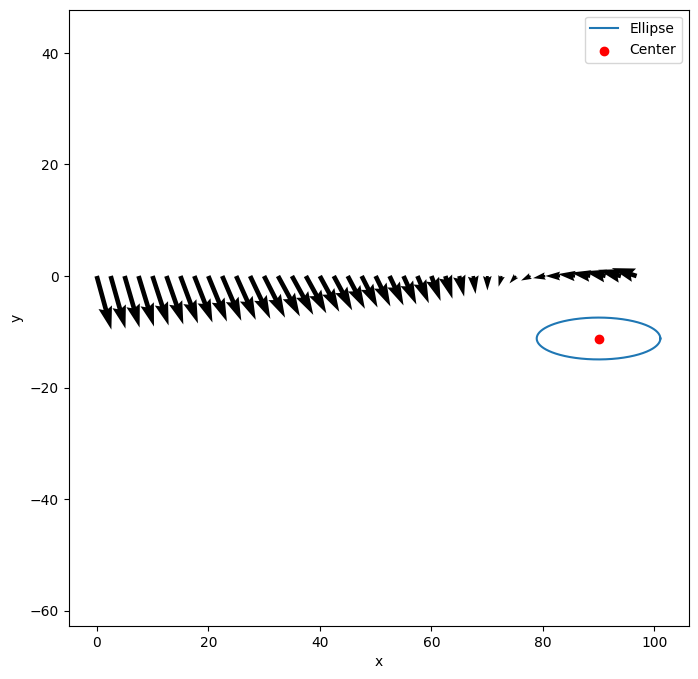

In [38]:
def polynomial_fit_with_error(x, y, degree=1):
    if degree not in [0, 1]:
        raise ValueError("Degree must be 0 or 1.")
    coefficients, cov = np.polyfit(x, y, degree, cov=True)  # coefficients = [slope, intercept]
    y_fit = np.polyval(coefficients, x)
    residuals = y - y_fit
    std_err_coeffs = np.sqrt(np.diag(cov))
    ss_total = np.sum((y - np.mean(y))**2)
    ss_residuals = np.sum(residuals**2)
    r_squared = 1 - (ss_residuals / ss_total)
    return coefficients, std_err_coeffs, r_squared

R = np.sqrt((lon_rho - edata.Lon)**2 + (lat_rho - edata.Lat)**2)
i_search, j_search = np.argwhere(R == np.min(R))[0]

SEARCH_WIDTH = 100000

i_left, i_right, _, _ = grid_finder(i_search, j_search, SEARCH_WIDTH)

l = distance(lat_rho[i_left, j_search], lon_rho[i_left, j_search], lat_rho[i_left:i_right, j_search], lon_rho[i_left:i_right, j_search])/1000

x = l
y = [0]*len(l)

DEPTH_LVL = 20

VL = u[i_left:i_right, j_search, DEPTH_LVL, t_mod]
VN = v[i_left:i_right, j_search, DEPTH_LVL, t_mod]

coefficients, std_err_coeffs, _ = polynomial_fit_with_error(l, VN, 1)
a = coefficients[0]
da = std_err_coeffs[0]
b = coefficients[1]
db = std_err_coeffs[1]

c, dc, _ = polynomial_fit_with_error(l, VL, 0)

Omega = a
r0 = c/a
l0 = -b/a

dr0 = (dc-da*r0)/a
dl0 = (db-da*l0)/a

x_perp, y_perp = l0, 0

xc = x_perp + r0/np.sqrt((1+1/a**2))
yc = y_perp - 1/a*(xc - x_perp)

value = 5.991  # The given value

# Parametric equations for the ellipse
theta = np.linspace(0, 2 * np.pi, 1000)
xx = xc + np.sqrt(2 * dr0**2 * value) * np.cos(theta)
yy = yc + np.sqrt(2 * dl0**2 * value) * np.sin(theta)

# Plotting the ellipse
plt.figure(figsize=(8, 8))

plt.quiver(x,y,VL,VN)

plt.plot(xx, yy, label='Ellipse')
plt.scatter(xc, yc, color='red', label='Center')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

In [22]:
rotate_30_clockwise(-1,0)

(array([-0.8660254]), array([-0.5]))